In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as np
plt.rcParams.update({'font.size': 25})

In [3]:
%cd ../..

/n/home10/rdeshpande/morphogenesis/jax-morph


In [4]:
from jax import random, vmap
from jax_md import space, quantity, util
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.datastructures import SpaceFunc
from jax_morph.utils import _maybe_array, logistic
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.division_and_growth.cell_division import S_cell_division, S_cell_div_indep, S_cell_div_indep_MC
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.cell_internals.stress import S_set_stress
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients
from jax_morph.cell_internals.hidden_state import hidden_state_nn, S_hidden_state

from jax_morph.initial_states import init_state_grow
from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate, draw_circles
from Ramya.mech_homogeneous_growth.chemical import S_fixed_chemfield

from functools import partial
import equinox as eqx
import haiku as hk

# For saving data
import pickle
import os

# Utils for easier organization
from Ramya.utils.gene_utils import default_params, build_sim_from_params, run_optimization
from Ramya.utils.gene_utils import position_sum_of_squares, v_metric

In [5]:
import warnings
warnings.filterwarnings('ignore')
from Francesco.ALIFE_plots import alife_utils
from Ramya.utils import gene_utils

In [6]:
%load_ext autoreload
%autoreload 2

# V-shape

## Set up gene network

In [7]:
init_key, subkey = random.split(random.PRNGKey(0), 2)
params_gn, train_params_gn = gene_utils.default_params(init_key, n_chem=20)
sim_gn = gene_utils.build_sim_from_params(params_gn, train_params_gn, subkey, n_inputs=62)

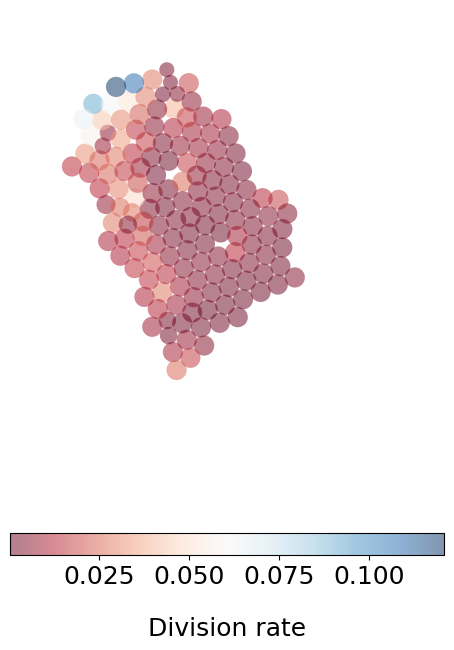

In [8]:
key = random.PRNGKey(26)
sim_init, sim_step = simulation(sim_gn.fstep, sim_gn.params, sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, sim_gn.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Division rate", normalize=False);

## Optimization

In [41]:
# Train just GN 
EPOCHS = 300
LEARNING_RATE = 1e-3 
SAVE_EVERY = 1
METRIC_FN = gene_utils.v_metric
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
key, train_key = random.split(key)
gn_loss, gn_params, gn_grads = gene_utils.run_optimization(train_key,
                                        sim_gn,
                                        METRIC_FN,
                                        metric_type='reward',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        save_grads=False,
                                        LAMBDA=0.1,
                                        )

Loss: 78.6042: 100%|█████████████████████████████████████████████████████████████████████| 300/300 [14:05<00:00,  2.82s/it]


In [53]:
with open('Ramya/data/gn_loss_vshape', 'wb') as handle:
    pickle.dump(gn_loss, handle)
with open('Ramya/data/gn_params_vshape', 'wb') as handle:
    pickle.dump(gn_params, handle)

In [43]:
with open('Ramya/data/gn_loss_vshape', 'rb') as handle:
    gn_loss = pickle.load(handle)
with open('Ramya/data/gn_params_vshape', 'rb') as handle:
    gn_params = pickle.load(handle)

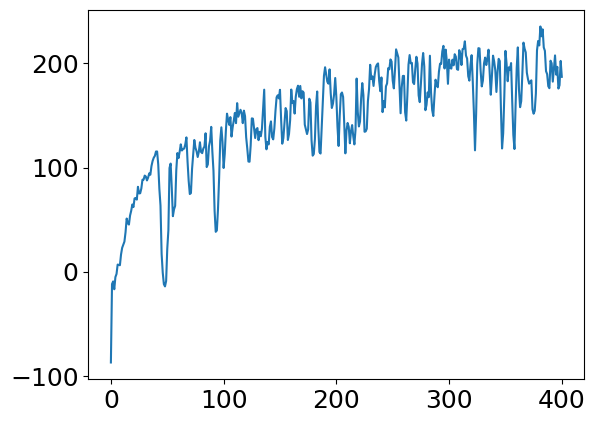

In [44]:
plt.plot(gn_loss);

In [45]:
gn_loss[-1]

187.1307830810547

In [54]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn_opt = SimulBlocks(sim_gn.fstep, sim_gn.fspace, sim_gn.istate, eqx.combine(gn_params[-1], sim_gn.params), sim_gn.train_params) #, sim_init, sim_step

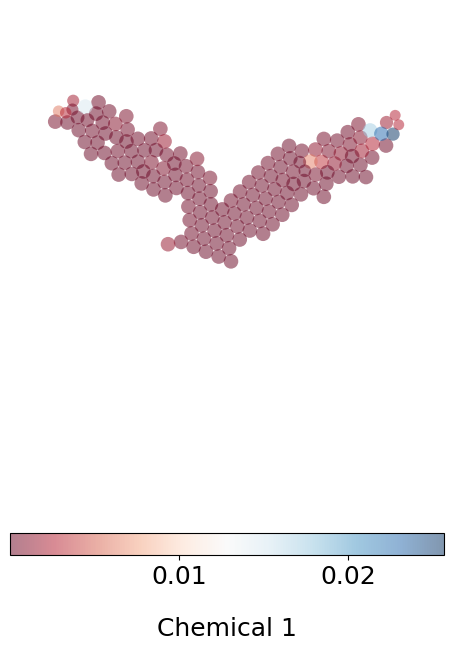

In [55]:
sim_init, sim_step = simulation(sim_gn_opt.fstep, sim_gn_opt.params, sim_gn_opt.fspace)
fstate_opt, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 1", normalize=False);

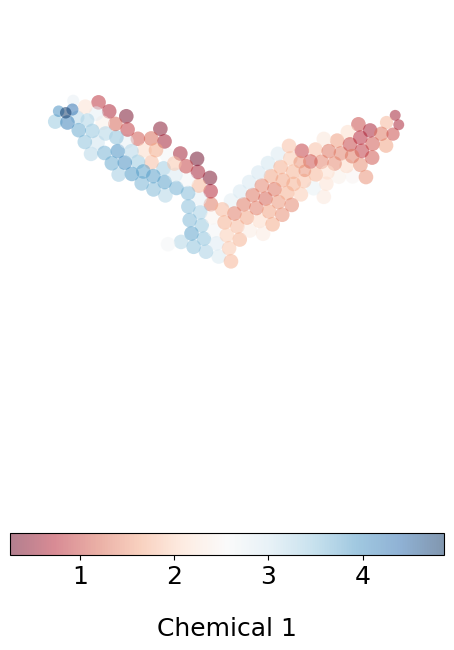

In [56]:
draw_circles(fstate_opt, fstate_opt.chemical[:, 19], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 1", normalize=False);

##   Pretraining with a neural network (not required!!)

In [6]:
from Ramya.utils import gene_utils
from Francesco.ALIFE_plots import alife_utils
from optax import piecewise_constant_schedule

In [11]:
# Regularized loss function
from jax import lax
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def loss_pretrained(params_nn,
         params_gn,
         hyper_params_nn,
         hyper_params_gn,
         fstep_nn,
         fstep_gn,
         fspace,
         istate_nn,
         istate_gn,
         alpha=1.0,
         sim_key=None,
         metric_fn=None,
         metric_type='reward',
         REINFORCE=True,
         GAMMA=.99,
         ncells_add=None,
         LAMBDA=0.0
         ):
    '''
    Reinforce loss on trajectory (with discounting). Rewards are differences in successive state metrics.

    If REINFORCE=False, then the loss is just the state measure on the final state.

    GAMMA is the discount factor for the calculation of the returns.

    If metric_type='reward', it is maximized, if metric_type='cost', it is minimized.

    '''

    #simulation length
    ncells_add = hyper_params_nn['ncells_add'] if ncells_add is None else ncells_add
    
    #def _measure_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

    #    state = sim_init(istate, ncells_add, key)

    #    def scan_fn(state, i):
    #        state, logp = sim_step(state)
    #        measure = metric_fn(state)
    #        return state, (logp, measure)
    #    iterations = np.arange(ncells_add)
    #    fstate, aux = lax.scan(scan_fn, state, iterations)
    #    return fstate, aux
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            return state, state
        iterations = np.arange(ncells_add)
        fstate, traj = lax.scan(scan_fn, state, iterations)
        return fstate, traj

    # merge params dicts
    all_params_nn = eqx.combine(params_nn, hyper_params_nn)
    all_params_gn = eqx.combine(params_gn, hyper_params_gn)

    #forward pass - simulation
    sim_init_nn, sim_step_nn = simulation(fstep_nn, all_params_nn, fspace)
    fstate_nn, traj_nn = _sim_trajectory(istate_nn, sim_init_nn, sim_step_nn, ncells_add, sim_key)
    
    sim_init_gn, sim_step_gn = simulation(fstep_gn, all_params_gn, fspace)
    fstate_gn, traj_gn = _sim_trajectory(istate_gn, sim_init_gn, sim_step_gn, ncells_add, sim_key)

    
    if REINFORCE:
        
        def _returns_rec(rewards):
            Gs=[]
            G=0
            for r in rewards[::-1]:
                G = r+G*GAMMA
                Gs.append(G)

            return np.array(Gs)[::-1]
        
        
        measures_nn = np.append(np.array([metric_fn(istate_nn)]),measures_nn)
        measures_gn = np.append(np.array([metric_fn(istate_gn)]),measures_gn)
        
        if metric_type=='reward':
            rewards_nn = np.diff(measures_nn)
            rewards_gn = np.diff(measures_gn)
        elif metric_type=='cost':
            rewards = -np.diff(measures_nn)
            rewards_gn = -np.diff(measures_gn)


        returns_nn = _returns_rec(rewards_nn)
        returns_gn = _returns_rec(rewards_gn)

        # standardizing returns helps with convergence
        returns_nn = (returns_nn-returns_nn.mean())/(returns_nn.std()+1e-8)
        returns_gn = (returns_gn-returns_gn.mean())/(returns_gn.std()+1e-8)

        loss_nn = -np.sum(logp_nn*lax.stop_gradient(returns_nn))
        loss_gn = -np.sum(logp_gn*lax.stop_gradient(returns_gn))

        if LAMBDA > 0.:
            if "gene_fn" in params_gn:
                loss_gn += LAMBDA*np.abs(params_gn["gene_fn"]).sum()
        loss = alpha*loss_nn + (1 - alpha)*loss_gn
        return loss

    else:
        return alpha*measures_nn[-1] + (1 - alpha)*measures_gn[-1]

In [12]:
#@eqx.filter_jit #NO JIT IS FASTER IN THIS CASE
def avg_loss_pretrained(params_nn, params_gn, hyper_params_nn, hyper_params_gn, vloss_fn, sim_keys, **kwargs):
    
    lss = vloss_fn(params_nn, params_gn, hyper_params_nn, hyper_params_gn, sim_key=sim_keys, **kwargs)
    
    return np.mean(lss)

In [13]:
### TRAIN FUNCTION ###
from jax import value_and_grad, tree_map
from optax import adam
from tqdm import trange
def train_pretrained(key, 
          EPOCHS, 
          EPISODES_PER_UPDATE, 
          EPISODES_PER_EVAL, 
          LEARNING_RATE, 
          train_loss, 
          eval_loss,
          sim_nn,
          sim_gn,
          normalize_grads=False,
          optimizer=adam,
          save_every=10,
          save_grads=False,
          ):

    p_nn, hp_nn = eqx.partition(sim_nn.params, sim_nn.train_params)
    p_gn, hp_gn = eqx.partition(sim_gn.params, sim_gn.train_params)

    # init optimizer
    optimizer = optimizer(LEARNING_RATE)
    #opt_state_nn = optimizer.init(p_nn)
    opt_state_gn = optimizer.init(p_gn)

    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)

    #ll_nn, grads_nn = value_and_grad(avg_loss_pretrained)(p_nn, p_gn, hp_nn, hp_gn, train_loss, batch_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)  
    ll_gn, grads_gn = value_and_grad(avg_loss_pretrained, argnums=1)(p_nn, p_gn, hp_nn, hp_gn, train_loss, batch_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)

    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss_pretrained(p_nn, p_gn, hp_nn, hp_gn, eval_loss, eval_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)

    #store initial params and loss
    loss_t = [float(l)]
    params_t = [(p_nn, p_gn)]
    grads_t = [grads_gn] if save_grads else None

    #--------------------------------------------

    pbar = trange(EPOCHS, desc='Loss: {:.4f}'.format(l))
    for t in pbar:
        
        try:
            #generate batch of random keys
            key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
            batch_subkeys = np.array(batch_subkeys)
        
            #normalize grads
            if normalize_grads:
                #grads_nn = tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), grads_nn)
                grads_gn = tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), grads_gn)


            # sgd step
            #updates_nn, opt_state_nn = optimizer.update(grads_nn, opt_state_nn, p_nn)
            #p_nn = eqx.apply_updates(p_nn, updates_nn)
            updates_gn, opt_state_gn = optimizer.update(grads_gn, opt_state_gn, p_gn)
            p_gn = eqx.apply_updates(p_gn, updates_gn)
        
            #clip diffCoeff if trained
            #if None != p_nn['diffCoeff']:
            #    p_nn['diffCoeff'] = np.clip(p_nn['diffCoeff'],.2)
            if None != p_gn['diffCoeff']:
                p_gn['diffCoeff'] = np.clip(p_gn['diffCoeff'],.2)
        
            #estimate actual avg loss
            key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
            eval_subkeys = np.array(eval_subkeys)

            l = avg_loss_pretrained(p_nn, p_gn, hp_nn, hp_gn, eval_loss, eval_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)
        
            # surrogate loss and grads
            #ll_nn, grads_nn = value_and_grad(avg_loss_pretrained)(p_nn, p_gn, hp_nn, hp_gn, train_loss, batch_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)
            ll_gn, grads_gn = value_and_grad(avg_loss_pretrained, argnums=1)(p_nn, p_gn, hp_nn, hp_gn, train_loss, batch_subkeys, fstep_nn=sim_nn.fstep, fstep_gn=sim_gn.fstep, fspace=sim_nn.fspace, istate_nn=sim_nn.istate, istate_gn=sim_gn.istate)
            loss_t += [float(l)]


            #store
            if t == EPOCHS-1:
                params_t += [(p_nn, p_gn)]
                if save_grads:
                    grads_t += [grads_gn]
                    
            elif t%save_every==0 and t>0:
                params_t += [(p_nn, p_gn)]
                if save_grads:
                    grads_t += [grads_gn]


            pbar.set_description('Loss: {:.4f}'.format(l))

        except FloatingPointError:
            print('NaN or Overflow')
            break

        except KeyboardInterrupt:
            print('Interrupted')
            break


    return loss_t, params_t, grads_t

In [14]:
def run_optimization_pretrained(train_key, 
                     sim_nn,
                     sim_gn,
                     metric_fn,
                     metric_type,
                     alpha=1.0,
                     epochs=10, 
                     episodes_per_update=4, 
                     episodes_per_eval=64, 
                     learning_rate=1e-3, 
                     optimizer=adam,
                     reinforce_gamma=.95,
                     save_every=10,
                     save_grads=False,
                     normalize_grads=True,
                     LAMBDA=0.0,
                     ):



    train_loss = eqx.filter_jit(partial(loss_pretrained, metric_fn=metric_fn, metric_type=metric_type, REINFORCE=True, GAMMA=reinforce_gamma, LAMBDA=LAMBDA, alpha=alpha))
    eval_loss = eqx.filter_jit(partial(loss_pretrained, metric_fn=metric_fn, REINFORCE=False, LAMBDA=LAMBDA, alpha=alpha))


    loss_t, params_t, grads_t = train_pretrained(train_key, 
                                    epochs, 
                                    episodes_per_update, 
                                    episodes_per_eval, 
                                    learning_rate, 
                                    train_loss, 
                                    eval_loss,
                                    sim_nn,
                                    sim_gn,
                                    normalize_grads=normalize_grads,
                                    optimizer=optimizer,
                                    save_every=save_every,
                                    save_grads=save_grads,
                                    )
    
    return loss_t, params_t, grads_t

In [15]:
# Set up NN and GN
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])

 # V-shape optimization loss curves
with open('Ramya/data/vshape_50_loss', 'rb') as handle:
    v_loss = pickle.load(handle)
with open('Ramya/data/vshape_50_params', 'rb') as handle:
    v_param = pickle.load(handle)

nn3_params, nn3_train_params = alife_utils.default_params(init_key, n_chem=3)
nn3_sim = alife_utils.build_sim_from_params(nn3_params, nn3_train_params, subkey)

idx = np.argmax(np.array(v_loss)[:, -1])
opt_param = eqx.combine(v_param[idx][-1], nn3_sim.params)
sim_nn_opt = SimulBlocks(nn3_sim.fstep, nn3_sim.fspace, nn3_sim.istate, opt_param, nn3_sim.train_params)

params_gn, train_params_gn = gene_utils.default_params(init_key, n_chem=3)
sim_gn = gene_utils.build_sim_from_params(params_gn, train_params_gn, subkey, n_inputs=11)

In [16]:
EPOCHS = 400
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100
#LEARNING_RATE = 1e-3
LEARNING_RATE = piecewise_constant_schedule(1e-3, {100: .2})
METRIC_FN = gene_utils.v_metric
SAVE_EVERY = 100

In [33]:
# Load losses for all alpha values
losses = []
alphas = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, .55, .5, .45, .4, .35, .3, .25, .2, .15, .1, .05, 0.0]
for alpha in alphas:
    with open('Ramya/data/loss_alpha_{}'.format(alpha), 'rb') as handle:
        losses.append(pickle.load(handle))

Text(0, 0.5, 'Reward')

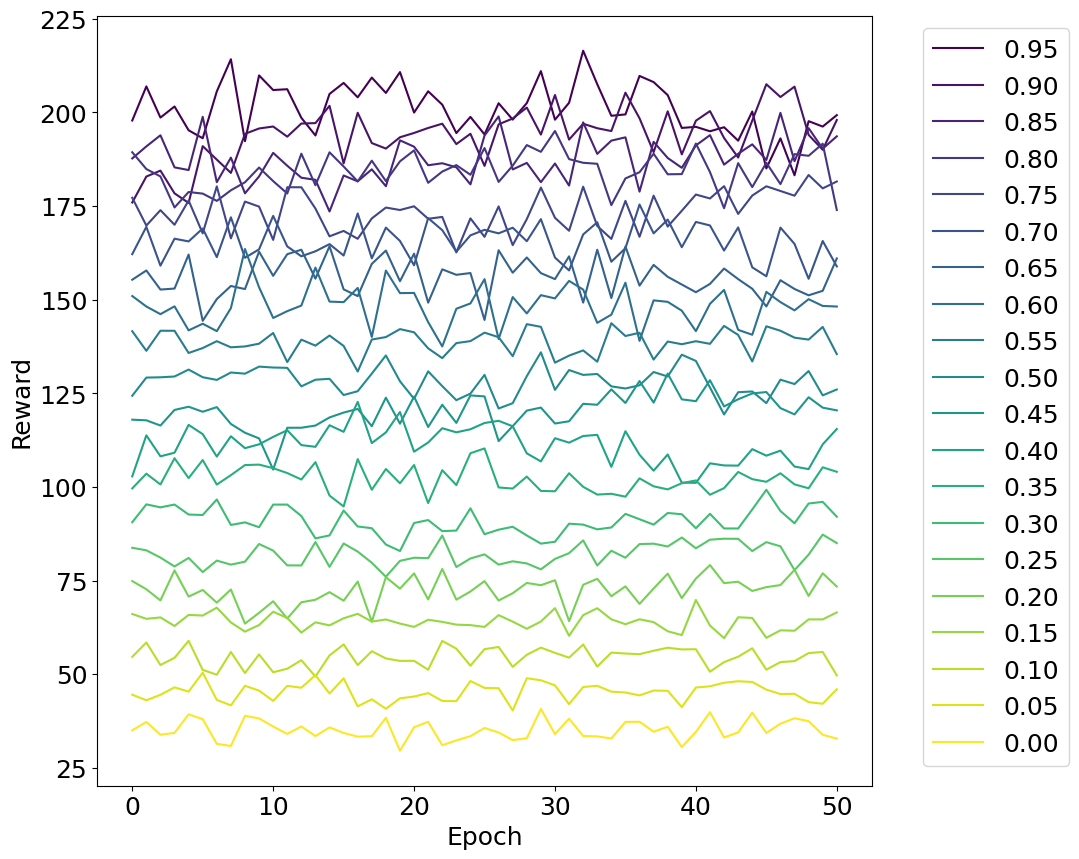

In [34]:
# Plot all losses with viridis color palette
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(losses)))
plt.figure(figsize=(10, 10))
for i, loss in enumerate(losses):
    plt.plot(loss, label='{:.2f}'.format(alphas[i]), color=colors[i])
    # Legend on right side of box
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Reward')

In [20]:
EPOCHS = 50
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
LEARNING_RATE = 1e-3
#LEARNING_RATE = piecewise_constant_schedule(1e-3, {100: .2})
METRIC_FN = gene_utils.v_metric
SAVE_EVERY = 100
#ri_sim_nn, ri_sim_gn = sim_nn_opt, sim_gn
for alpha in [0.0]:
    print('alpha = {}'.format(alpha))
    key, train_key = random.split(key)
    ri_loss, ri_params, _ = run_optimization_pretrained(train_key,
                                        ri_sim_nn,
                                        ri_sim_gn,
                                        METRIC_FN,
                                        metric_type='reward',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        LAMBDA=0.1,
                                        alpha=alpha,
                                        )
    # Save params and loss with alpha value in file name
    #with open('Ramya/data/params_alpha_{}'.format(alpha), 'wb') as handle:
    #    pickle.dump(ri_params, handle)
    #with open('Ramya/data/loss_alpha_{}'.format(alpha), 'wb') as handle:
    #    pickle.dump(ri_loss, handle)
    ri_sim_nn = SimulBlocks(sim_nn_opt.fstep, sim_nn_opt.fspace, sim_nn_opt.istate, eqx.combine(ri_params[-1][0], sim_nn_opt.params), sim_nn_opt.train_params)
    ri_sim_gn = SimulBlocks(sim_gn.fstep, sim_gn.fspace, sim_gn.istate, eqx.combine(ri_params[-1][1], sim_gn.params), sim_gn.train_params)

alpha = 0.0


Loss: 39.7727: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


## Analyzing network

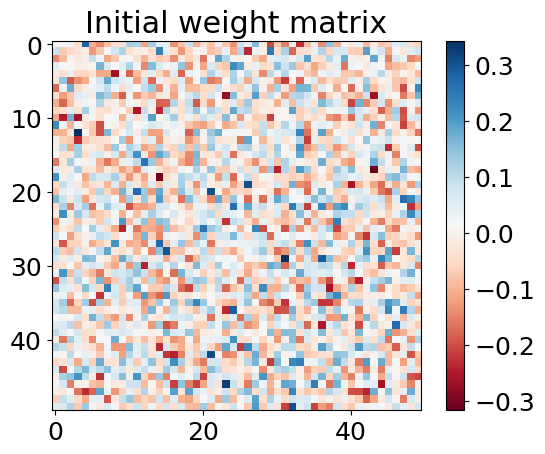

In [74]:
plt.imshow(sim_gn.params["gene_fn"][:50, :50], cmap='RdBu')
plt.colorbar();
plt.title("Initial weight matrix");

Text(0.5, 1.0, 'Final weight matrix')

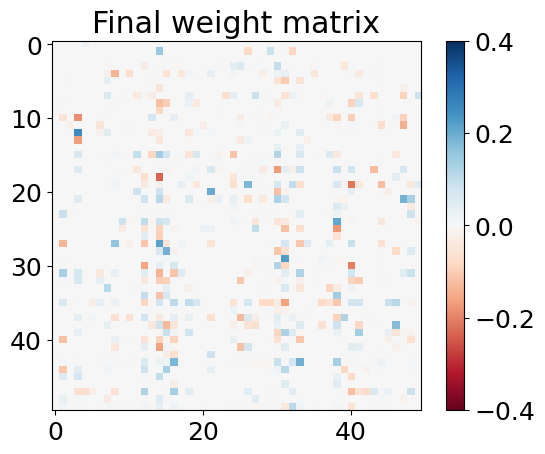

In [75]:
plt.imshow(sim_gn_opt.params["gene_fn"][:50, :50], cmap='RdBu', vmin=-0.4, vmax=0.4)
plt.colorbar();
plt.title("Final weight matrix")

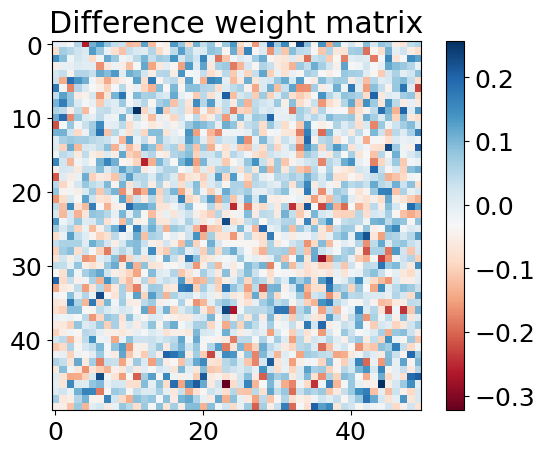

In [76]:
plt.imshow((sim_gn_opt.params["gene_fn"] - sim_gn.params["gene_fn"])[:50, :50], cmap='RdBu')
plt.colorbar();
plt.title("Difference weight matrix");

In [77]:
# Way too many weights!
print("Num weights: " + str(len(sim_gn_opt.params["gene_fn"])**2))

Num weights: 54289


In [198]:
# Measure loss with different amounts of pruning
def prune_loss(key, sim, eps, metric_fn=gene_utils.v_metric):
    pruned_p = deepcopy(sim.params)
    W = np.where(np.abs(sim.params["gene_fn"])>eps, sim.params["gene_fn"], 0)
    pruned_p["gene_fn"] = np.where(np.abs(sim.params["gene_fn"])>eps, sim.params["gene_fn"], 0)
    sim_init, sim_step = simulation(sim.fstep, pruned_p, sim.fspace)
    fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
    return metric_fn(fstate)
prune_loss_vmap = vmap(prune_loss, (0, None, 0, None))

In [110]:
keys = random.split(key, 1000)
epsilons = np.array([10**i for i in np.linspace(-2, -0.4, 1000)])
losses = prune_loss_vmap(keys, sim_gn_opt, epsilons, gene_utils.v_metric)

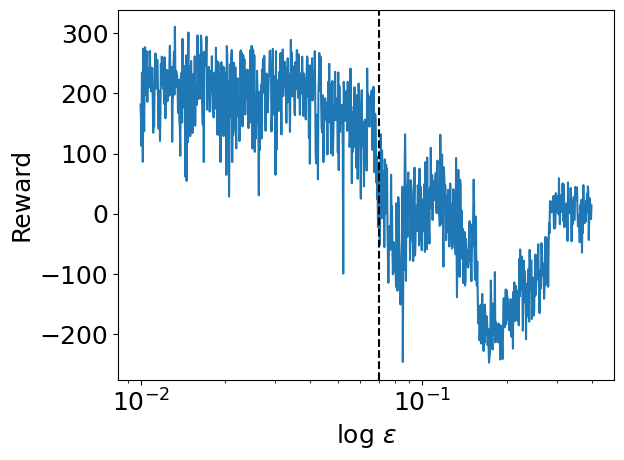

In [111]:
plt.plot(epsilons, losses)
plt.xscale('log');
plt.xlabel(r'log $\epsilon$')
plt.ylabel('Reward');
plt.axvline(0.07, 0.0, 300.0, linestyle="dashed", color='black');

In [112]:
# Can we prune it?
import networkx as nx
eps = 0.07
W = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
print("Num weights: " + str(np.count_nonzero(W)))

Num weights: 1336


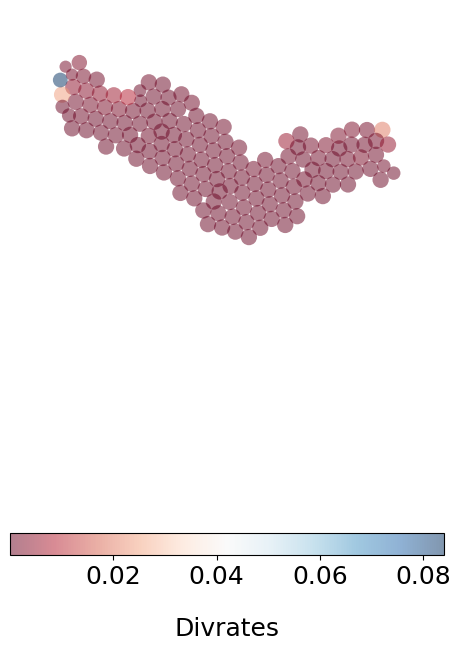

In [114]:
pruned_p = deepcopy(sim_gn_opt.params)
pruned_p["gene_fn"] = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
sim_init, sim_step = simulation(sim_gn_opt.fstep, pruned_p, sim_gn_opt.fspace)
fstate, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Divrates", normalize=False);

In [115]:
# Re-optimize with pruned params
sim_gn_pruned = SimulBlocks(sim_gn_opt.fstep, sim_gn_opt.fspace, sim_gn_opt.istate, pruned_p, sim_gn_opt.train_params) #, sim_init, sim_step
# Train just GN 
EPOCHS = 300
LEARNING_RATE = 1e-3 
SAVE_EVERY = 1
METRIC_FN = gene_utils.v_metric
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
key, train_key = random.split(key)
gn_loss_pruned, gn_params_pruned, gn_grads_pruned = gene_utils.run_optimization(train_key,
                                        sim_gn_pruned,
                                        METRIC_FN,
                                        metric_type='reward',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        save_grads=False,
                                        LAMBDA=0.1,
                                        )

Loss: 216.9004: 100%|████████████████████████████████████████████████████████████████████| 300/300 [11:41<00:00,  2.34s/it]


In [116]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn_pruned_opt = SimulBlocks(sim_gn_pruned.fstep, sim_gn_pruned.fspace, sim_gn_pruned.istate, eqx.combine(gn_params_pruned[-1], sim_gn_pruned.params), sim_gn_pruned.train_params) #, sim_init, sim_step

In [117]:
keys = random.split(key, 1000)
epsilons = np.array([10**i for i in np.linspace(-2, -0.4, 1000)])
losses = prune_loss_vmap(keys, sim_gn_pruned_opt, epsilons, gene_utils.v_metric)

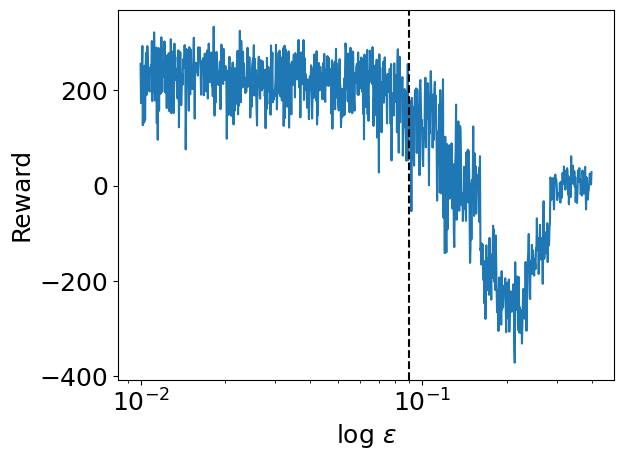

In [126]:
plt.plot(epsilons, losses)
plt.xscale('log');
plt.xlabel(r'log $\epsilon$')
plt.ylabel('Reward');
plt.axvline(0.09, 0.0, 300.0, linestyle="dashed", color='black');

Num weights: 553


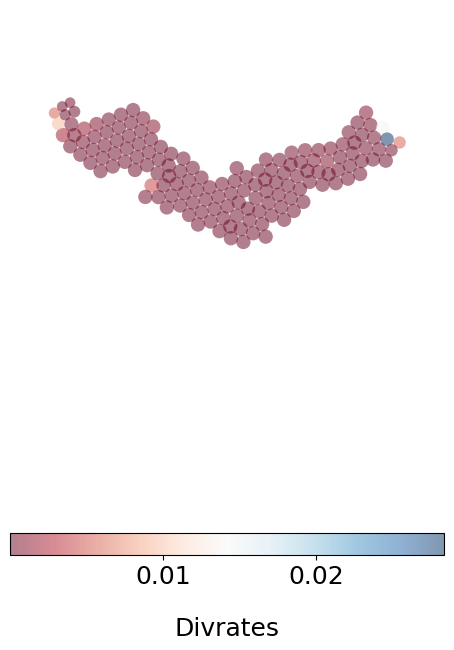

In [128]:
# Works with less weights now!
eps = 0.08
pruned_p = deepcopy(sim_gn_pruned_opt.params)
pruned_p["gene_fn"] = np.where(np.abs(sim_gn_pruned_opt.params["gene_fn"])>eps, sim_gn_pruned_opt.params["gene_fn"], 0)
print("Num weights: " + str(np.count_nonzero(pruned_p["gene_fn"])))
sim_init, sim_step = simulation(sim_gn_pruned_opt.fstep, pruned_p, sim_gn_pruned_opt.fspace)
fstate, _ = sim_trajectory(sim_gn_pruned_opt.istate, sim_init, sim_step, sim_gn_pruned_opt.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Divrates", normalize=False);

In [129]:
with open('Ramya/data/gn_loss_vshape_pruned', 'wb') as handle:
    pickle.dump(gn_loss_pruned, handle)
with open('Ramya/data/gn_params_vshape_pruned', 'wb') as handle:
    pickle.dump(gn_params_pruned, handle)

In [12]:
with open('Ramya/data/gn_loss_vshape_pruned', 'rb') as handle:
    gn_loss_pruned = pickle.load(handle)
with open('Ramya/data/gn_params_vshape_pruned', 'rb') as handle:
    gn_params_pruned = pickle.load(handle)
gn_params_pruned = eqx.combine(gn_params_pruned[-1], sim_gn.params)

In [14]:
NUM_INPUTS = 62
NUM_OUTPUTS = gn_params_pruned["n_chem"] + 1
NUM_HIDDEN = gn_params_pruned["gene_fn"].shape[0] - NUM_INPUTS - NUM_OUTPUTS
node_color = ["maroon"]*NUM_INPUTS + ["black"]*NUM_HIDDEN + ["pink"]*NUM_OUTPUTS

In [87]:
rows, cols = np.argwhere(np.all(W == 0, axis=0)), np.argwhere(np.all(W == 0, axis=1))
zero_genes = [int(i) for i in range(NUM_INPUTS, NUM_INPUTS + NUM_HIDDEN) if i in rows and i in cols]
nonzero_genes = np.array([i for i in range(len(W)) if i not in zero_genes])
eps = .08
W = np.where(np.abs(gn_params_pruned["gene_fn"])>eps, gn_params_pruned["gene_fn"], 0)
W_red = W[nonzero_genes, :][:, nonzero_genes]
node_colors = ["violet"]*NUM_INPUTS + ["limegreen"]*(len(W_red) - NUM_INPUTS - NUM_OUTPUTS) + ["darkorange"]*NUM_OUTPUTS
node_sizes = [100]*NUM_INPUTS + [30]*(len(W_red) - NUM_INPUTS - NUM_OUTPUTS) + [100]*NUM_OUTPUTS

Text(0.5, 1.0, 'Gene network')

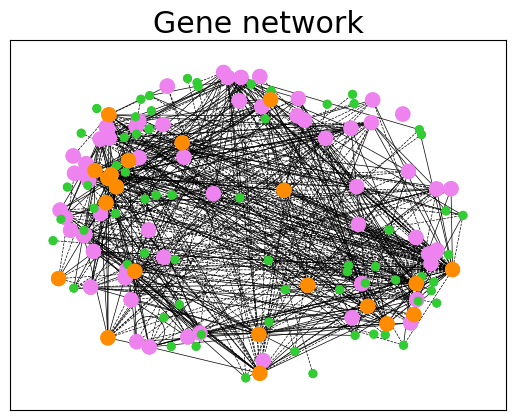

In [88]:
# Visualize network
G = nx.from_numpy_array(W_red)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
plt.title("Gene network")

## Regeneration

In [90]:
from copy import deepcopy

In [94]:
# Run simulation for longer
eps = 0.08
pruned_p = deepcopy(gn_params_pruned)
pruned_p["gene_fn"] = np.where(np.abs(pruned_p["gene_fn"])>eps, pruned_p["gene_fn"], 0)
sim_init, sim_step = simulation(sim_gn.fstep, pruned_p, sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, 1000, key, history=False)

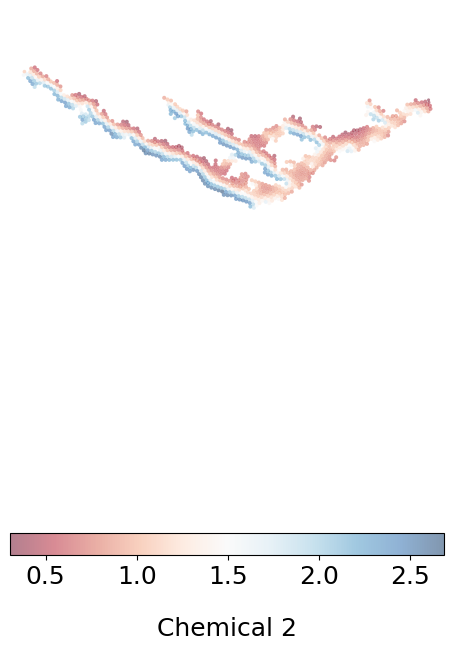

In [97]:
draw_circles(fstate, fstate.chemical[:, 4], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 2", normalize=False);

In [98]:
from tqdm import tqdm
def kill_random(key, state, kill_rate=.3):
    '''Kill cells randomly'''

    ncells = int((state.celltype > 0).sum())
    nkill = int(ncells * kill_rate)

    #randomly select cells to kill
    kill_idx = random.choice(key, ncells, shape=(nkill,), replace=False)

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


In [106]:
sim_init, sim_step = simulation(sim_gn.fstep, pruned_p, sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, sim_gn.params["ncells_add"], key, history=False)

In [107]:
# Regeneration plots
kill_rates = np.linspace(.0, .9, 7)
n_avg = 15
METRIC_FN = v_metric
N_CELLS = int((fstate.celltype > 0).sum())
n_kills = (kill_rates * N_CELLS).astype(int)
kill_rates = n_kills / N_CELLS #recalculate actual kill rates

regen_metrics_avg = []
regen_metrics_std = []

for kr, nk in zip(kill_rates, n_kills):
    reps = []
    for i in tqdm(np.arange(n_avg), desc='kill rate: ' + str(kr)):
        key, subkey, subkey_reg = random.split(key, 3)

        kill_state = kill_random(subkey, fstate, kill_rate=kr)

        #forward pass - simulation
        sim_init, sim_step = simulation(sim_gn.fstep, gn_params_pruned, sim_gn.fspace)
        regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=nk, key=subkey_reg)

        reps += [float(METRIC_FN(regen_state))]

    reps = np.array(reps)
    regen_metrics_avg += [float(np.mean(reps))]
    regen_metrics_std += [float(np.std(reps))]

kill rate: 0.9: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:39<00:00,  2.65s/it]


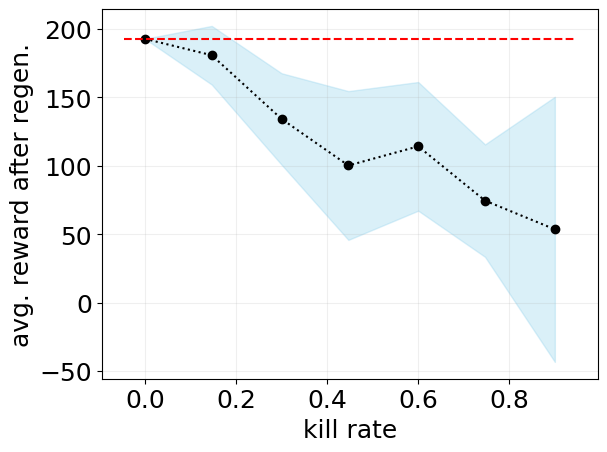

In [108]:
#plot results
regen_metrics_avg = np.array(regen_metrics_avg)
plt.plot(kill_rates.tolist(), regen_metrics_avg, 'ko:')
plt.fill_between(kill_rates.tolist(), np.array(regen_metrics_avg) - np.array(regen_metrics_std), np.array(regen_metrics_avg) + np.array(regen_metrics_std), alpha=.3, color='skyblue')
plt.hlines(v_metric(fstate), *plt.gca().get_xlim(), linestyles='dashed', color='r')
plt.xlabel('kill rate')
plt.ylabel('avg. reward after regen.')
plt.grid(alpha=.2)

# Homogeneous growth

## Set up gene network

In [135]:
transform_field = lambda state, div: div*state.field
use_state_fields = gene_utils.CellState(position=False, celltype=False, radius=True, chemical=True,chemgrad=True,field=False,divrate=True,gene_vec=False,stress=True,key=False)

In [136]:
init_key, subkey = random.split(random.PRNGKey(0), 2)
params_gn, train_params_gn = gene_utils.default_params(init_key, n_chem=20)
params_gn["ncells_init"] = 100
params_gn["ncells_add"] = 100
params_gn["hidden_genes"] = 128
sim_gn = gene_utils.build_sim_from_params(params_gn, train_params_gn, use_state_fields, subkey, n_inputs=63, div_fwd=transform_field)

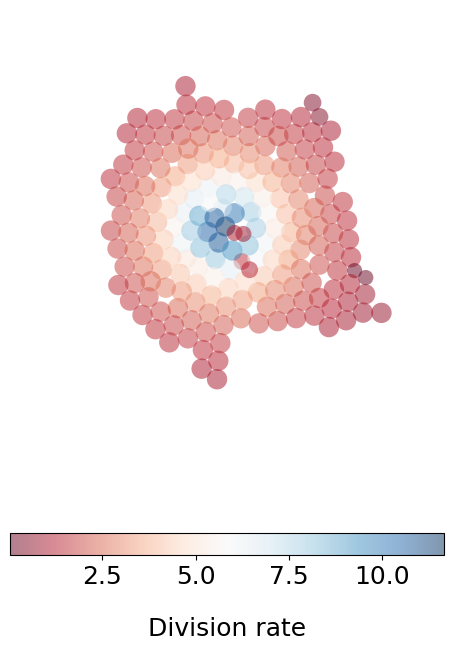

In [137]:
key = random.PRNGKey(26)
sim_init, sim_step = simulation(sim_gn.fstep, sim_gn.params, sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, sim_gn.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Division rate", normalize=False);

## Optimization

In [241]:
# Only works without REINFORCE
EPOCHS = 300
LEARNING_RATE = 1e-2
SAVE_EVERY = 1
METRIC_FN = gene_utils.cv_divrates
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
key, train_key = random.split(key)
gn_loss, gn_params, gn_grads = gene_utils.run_optimization(train_key,
                                        sim_gn,
                                        METRIC_FN,
                                        metric_type='cost',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        save_grads=False,
                                        LAMBDA=0.1,
                                        reinforce=False,
                                        )

Loss: 0.1679:  42%|█████████████████████████████▏                                        | 125/300 [07:00<09:49,  3.37s/it]

Interrupted


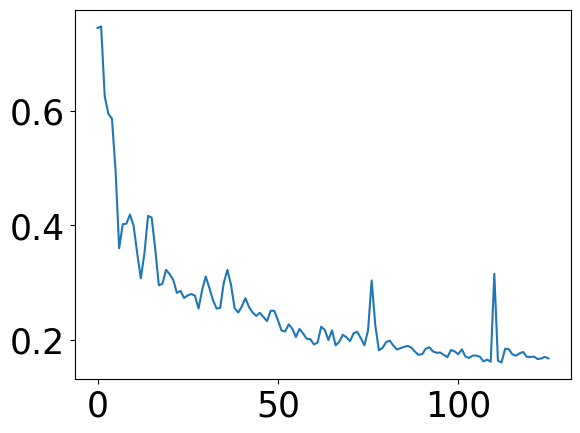

In [242]:
plt.plot(gn_loss);

In [246]:
with open('Ramya/data/gn_loss_homggrowth', 'wb') as handle:
    pickle.dump(gn_loss, handle)
with open('Ramya/data/gn_params_homoggrowth', 'wb') as handle:
    pickle.dump(gn_params, handle)

In [247]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn_opt = SimulBlocks(sim_gn.fstep, sim_gn.fspace, sim_gn.istate, eqx.combine(gn_params[-1], sim_gn.params), sim_gn.train_params) #, sim_init, sim_step

In [248]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn_opt = SimulBlocks(sim_gn.fstep, sim_gn.fspace, sim_gn.istate, eqx.combine(gn_params[-1], sim_gn.params), sim_gn.train_params) #, sim_init, sim_step

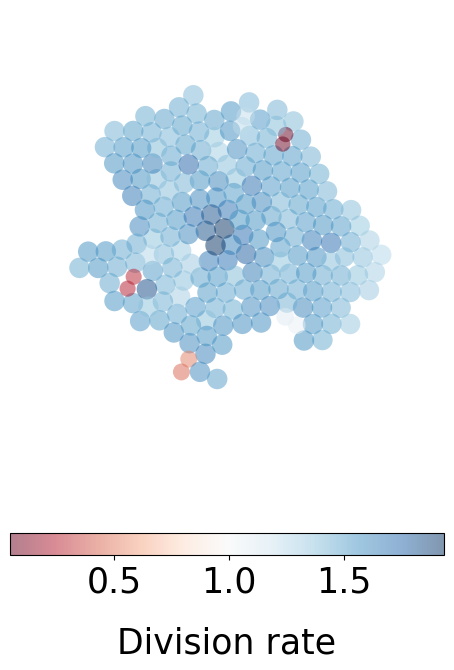

In [250]:
sim_init, sim_step = simulation(sim_gn_opt.fstep, sim_gn_opt.params, sim_gn_opt.fspace)
fstate_opt, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Division rate", normalize=False);

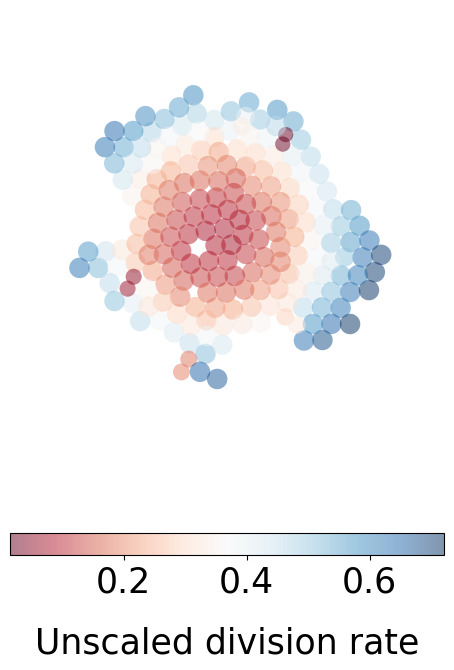

In [252]:
sim_init, sim_step = simulation(sim_gn_opt.fstep, sim_gn_opt.params, sim_gn_opt.fspace)
fstate_opt, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate/fstate_opt.field, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Unscaled division rate", normalize=False);

## Analyze network

In [253]:
# Way too many weights!
print("Num weights: " + str(len(sim_gn_opt.params["gene_fn"])**2))

Num weights: 44944


In [259]:
# Can we prune it?
import networkx as nx
eps = 0.5
W = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
print("Num weights: " + str(np.count_nonzero(W)))

Num weights: 132


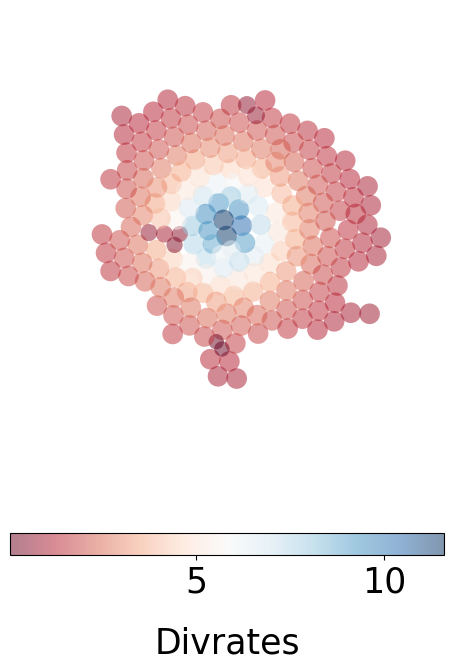

In [260]:
# of course won't work with arbitrary pruning 
pruned_p = deepcopy(sim_gn_opt.params)
pruned_p["gene_fn"] = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
sim_init, sim_step = simulation(sim_gn_opt.fstep, pruned_p, sim_gn_opt.fspace)
fstate, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Divrates", normalize=False);

In [263]:
# Need to re-optimize
sim_gn_pruned = SimulBlocks(sim_gn_opt.fstep, sim_gn_opt.fspace, sim_gn_opt.istate, pruned_p, sim_gn_opt.train_params) #, sim_init, sim_step
# Optimize this pruned network to get something more parsimonious
# Train just GN 
EPOCHS = 200
LEARNING_RATE = 1e-2
SAVE_EVERY = 1
METRIC_FN = gene_utils.cv_divrates
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
key, train_key = random.split(key)
gn_loss_pruned, gn_params_pruned, gn_grads_pruned = gene_utils.run_optimization(train_key,
                                        sim_gn_pruned,
                                        METRIC_FN,
                                        metric_type='reward',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        save_grads=False,
                                        reinforce=False,
                                        LAMBDA=0.1,
                                        )

Loss: 0.1908: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [11:11<00:00,  3.36s/it]


In [273]:
# Try pruning again - much smalle number of weights!
eps = 0.3
sim_gn_pruned_opt = SimulBlocks(sim_gn_pruned.fstep, sim_gn_pruned.fspace, sim_gn_pruned.istate, eqx.combine(gn_params_pruned[-1], sim_gn_pruned.params), sim_gn_pruned.train_params) #, sim_init, sim_step
W_ = np.where(np.abs(sim_gn_pruned_opt.params["gene_fn"])>eps, sim_gn_pruned_opt.params["gene_fn"], 0)
print("Num weights: " + str(np.count_nonzero(W_)))

Num weights: 190


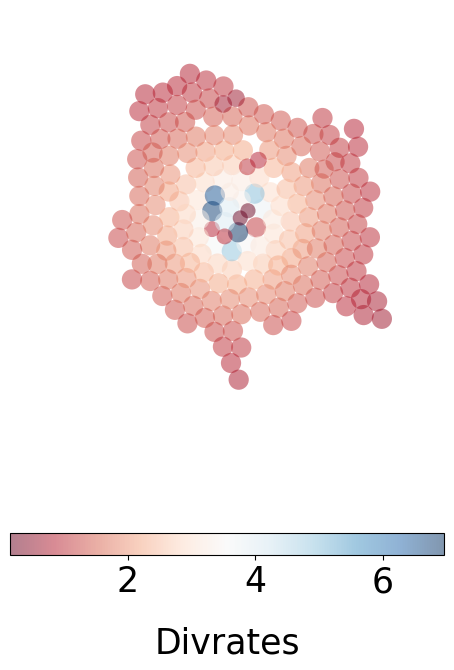

In [274]:
# works a bit better - need to tweak optimization
pruned_p = deepcopy(sim_gn_opt.params)
pruned_p["gene_fn"] = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
sim_init, sim_step = simulation(sim_gn_opt.fstep, pruned_p, sim_gn_opt.fspace)
fstate, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Divrates", normalize=False);

Text(0.5, 1.0, 'Synthetic gene network')

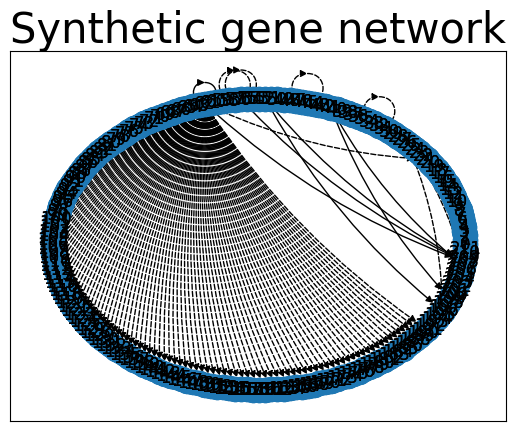

In [275]:
# Visualize network
# wtf is this?!?!?
G = nx.from_numpy_array(W_.T, create_using=nx.DiGraph)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0])
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0])
plt.title("Synthetic gene network")

# Chemical Homeostasis

## Set up gene network

In [182]:
init_key, subkey = random.split(random.PRNGKey(0), 2)
params_gn, train_params_gn = gene_utils.default_params(init_key, n_chem=5)
params_gn["ctype_sec_chem"] = np.identity(params_gn["n_chem"], dtype=np.int16)
params_gn["n_celltype"] = 2
train_params_gn["n_celltype"] = False
params_gn["ncells_init"] = 10*params_gn["n_celltype"]
params_gn["ncells_add"] = 150
params_gn["hidden_genes"] = 32
use_state_fields = gene_utils.CellState(position=False, celltype=False, radius=True, chemical=True,chemgrad=True,field=False,divrate=True,gene_vec=False,stress=True,key=False)
n_inputs = params_gn["n_chem"] + 2*params_gn["n_chem"] + 3
sim_gn = gene_utils.build_sim_from_params(params_gn, train_params_gn, use_state_fields, subkey, n_inputs=n_inputs, div_fwd=transform_field)

In [183]:
# Update istate to have different celltypes
istate = sim_gn.istate
istate = jdc.replace(istate, celltype=istate.celltype.at[:4].set(2))
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn = SimulBlocks(sim_gn.fstep, sim_gn.fspace, istate, sim_gn.params, sim_gn.train_params) #, sim_init, sim_step

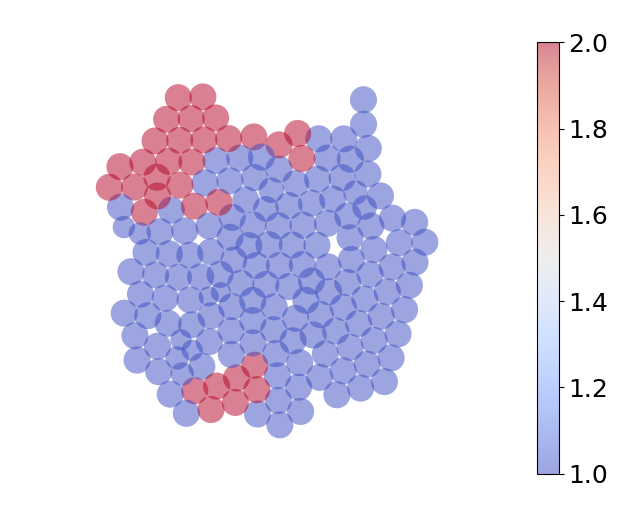

In [185]:
key = random.PRNGKey(26)
sim_init, sim_step = simulation(sim_gn.fstep, sim_gn.params, sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, sim_gn.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.celltype, normalize=False);

## Optimization

In [186]:
def ctype_diff_metric(state):
    '''
    Evaluate the difference between the number of cells of each type.
    '''
    entropy=0

    ncells=np.sum(np.where(state.celltype>0,1,0))
    ntypes=np.max(state.celltype)
    max_entropy=np.log(1/ntypes)

    for i in range(2):
        p=np.sum(np.where(state.celltype==i+1,1,0))/ncells
        entropy+=p*np.log(p)

    entropy=entropy/max_entropy    
    return entropy

In [189]:
EPOCHS = 200
LEARNING_RATE = 1e-3
SAVE_EVERY = 1
METRIC_FN = ctype_diff_metric
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64
key, train_key = random.split(key)
gn_loss, gn_params, gn_grads = gene_utils.run_optimization(train_key,
                                        sim_gn,
                                        METRIC_FN,
                                        metric_type='reward',
                                        epochs=EPOCHS,
                                        episodes_per_update=EPISODES_PER_UPDATE,
                                        episodes_per_eval=EPISODES_PER_EVAL,
                                        learning_rate=LEARNING_RATE,
                                        save_every=SAVE_EVERY,
                                        save_grads=False,
                                        LAMBDA=0.1,
                                        reinforce=True,
                                        )

Loss: 0.9320: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:02<00:00,  3.01s/it]


Text(0, 0.5, 'Entropy reward')

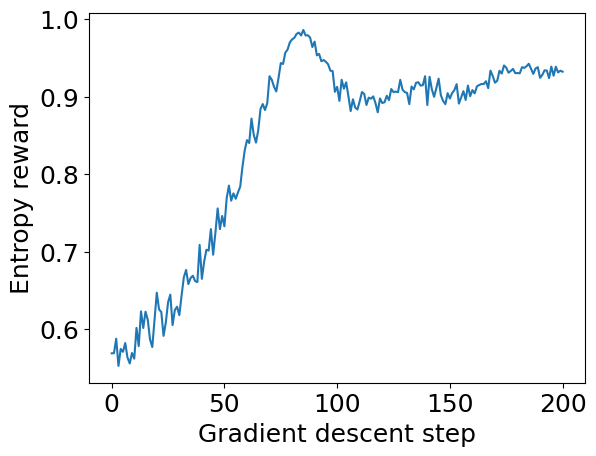

In [191]:
plt.plot(gn_loss)
plt.xlabel("Gradient descent step")
plt.ylabel("Entropy reward")

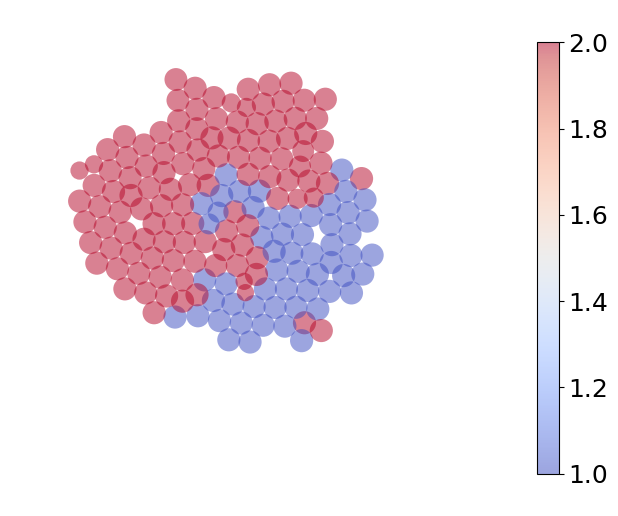

In [192]:
key, _ = random.split(key)
sim_init, sim_step = simulation(sim_gn.fstep, eqx.combine(gn_params[-1], sim_gn.params), sim_gn.fspace)
fstate, _ = sim_trajectory(sim_gn.istate, sim_init, sim_step, sim_gn.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.celltype, normalize=False);

In [207]:
with open('Ramya/data/gn_loss_homeostasis', 'wb') as handle:
    pickle.dump(gn_loss, handle)
with open('Ramya/data/gn_params_homeostasis', 'wb') as handle:
    pickle.dump(gn_params, handle)

## Analyze network

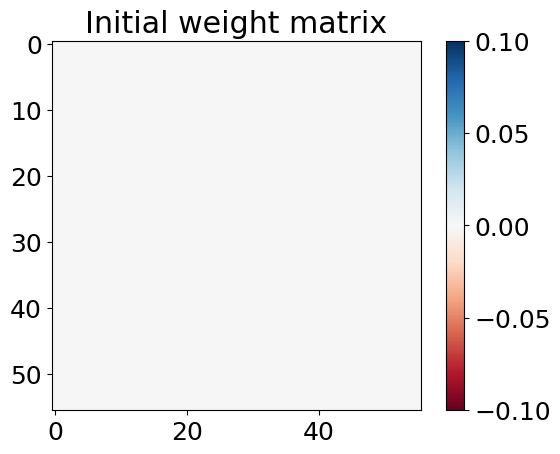

In [195]:
plt.imshow(sim_gn.params["gene_fn"], cmap='RdBu')
plt.colorbar();
plt.title("Initial weight matrix");

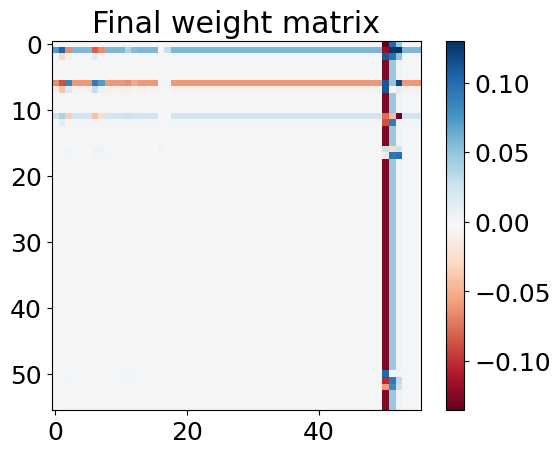

In [197]:
plt.imshow(gn_params[-1]["gene_fn"], cmap='RdBu')
plt.colorbar();
plt.title("Final weight matrix");

In [199]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim_gn_opt = SimulBlocks(sim_gn.fstep, sim_gn.fspace, sim_gn.istate, eqx.combine(gn_params[-1], sim_gn.params), sim_gn.train_params) #, sim_init, sim_step

In [204]:
keys = random.split(key, 100)
epsilons = np.array([10**i for i in np.linspace(-2, -0.4, 100)])
losses = prune_loss_vmap(keys, sim_gn_opt, epsilons, ctype_diff_metric)

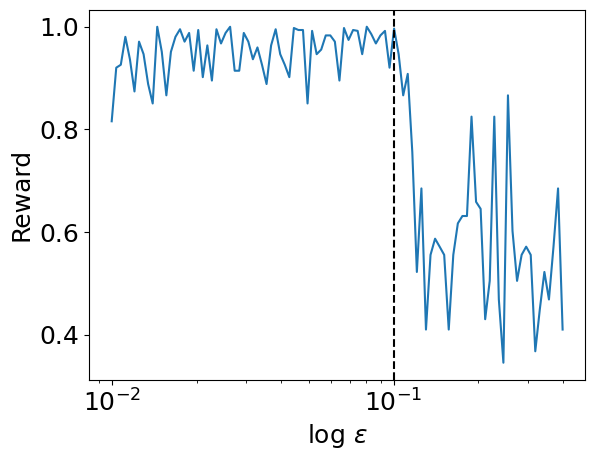

In [206]:
plt.plot(epsilons, losses)
plt.xscale('log');
plt.xlabel(r'log $\epsilon$')
plt.ylabel('Reward');
plt.axvline(0.1, 0.0, 300.0, linestyle="dashed", color='black');

Num weights: 57


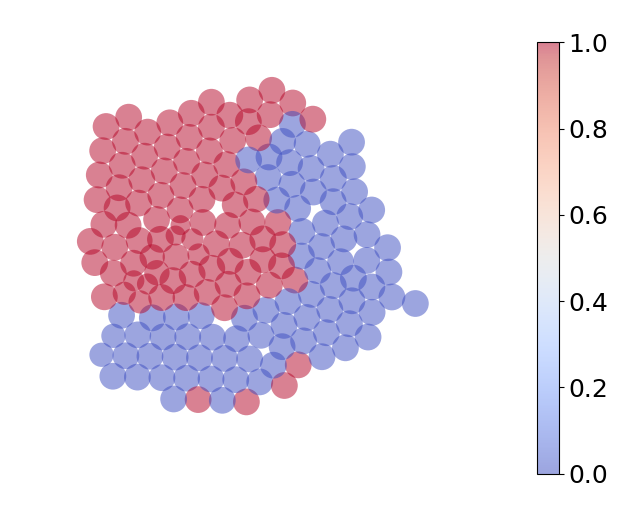

In [208]:
# Pruned weights
eps = 0.1
pruned_p = deepcopy(sim_gn_opt.params)
pruned_p["gene_fn"] = np.where(np.abs(sim_gn_opt.params["gene_fn"])>eps, sim_gn_opt.params["gene_fn"], 0)
print("Num weights: " + str(np.count_nonzero(pruned_p["gene_fn"])))
sim_init, sim_step = simulation(sim_gn_opt.fstep, pruned_p, sim_gn_opt.fspace)
fstate, _ = sim_trajectory(sim_gn_opt.istate, sim_init, sim_step, sim_gn_opt.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.celltype);

In [214]:
gn_params_pruned = eqx.combine(pruned_p, sim_gn.params)
with open('Ramya/data/gn_params_homeostasis_pruned', 'wb') as handle:
    pickle.dump(gn_params_pruned, handle)

In [215]:
with open('Ramya/data/gn_params_homeostasis_pruned', 'rb') as handle:
    gn_params_pruned = pickle.load(handle)

In [216]:
NUM_INPUTS = n_inputs
NUM_OUTPUTS = gn_params_pruned["n_chem"] + 1
NUM_HIDDEN = gn_params_pruned["gene_fn"].shape[0] - NUM_INPUTS - NUM_OUTPUTS
node_color = ["maroon"]*NUM_INPUTS + ["black"]*NUM_HIDDEN + ["pink"]*NUM_OUTPUTS

In [218]:
rows, cols = np.argwhere(np.all(W == 0, axis=0)), np.argwhere(np.all(W == 0, axis=1))
zero_genes = [int(i) for i in range(NUM_INPUTS, NUM_INPUTS + NUM_HIDDEN) if i in rows and i in cols]
nonzero_genes = np.array([i for i in range(len(W)) if i not in zero_genes])
eps = .08
W = np.where(np.abs(gn_params_pruned["gene_fn"])>eps, gn_params_pruned["gene_fn"], 0)
W_red = W[nonzero_genes, :][:, nonzero_genes]
node_colors = ["violet"]*NUM_INPUTS + ["limegreen"]*(len(W_red) - NUM_INPUTS - NUM_OUTPUTS) + ["darkorange"]*NUM_OUTPUTS
node_sizes = [100]*NUM_INPUTS + [30]*(len(W_red) - NUM_INPUTS - NUM_OUTPUTS) + [100]*NUM_OUTPUTS

Text(0.5, 1.0, 'Gene network')

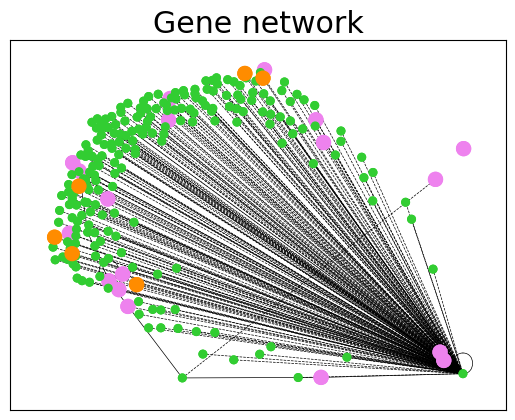

In [219]:
# Visualize network
G = nx.from_numpy_array(W_red)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
plt.title("Gene network")